# Training a machine learning classifier on resting state fMRI or structural MRI data

The goal is to train a classifier on MRI data. Two suitable data sets were identified.

## Getting the data

The ABIDE data set can be downloaded using nilearn. The data set contains resting state functional magnetic resonance imaging (rs-fMRI) data from multiple sites. Some of the participants had Autism Spectrum Disorder (ASD). This dataset could be used to train a classifier to distinguish ASD and control participants based on the resting state data.

The data were preprocessed with different pipelines. We will download the data preprocessed with the CPAC pipeline. For more on the differences between pipelines see [here](http://preprocessed-connectomes-project.org/abide/Pipelines.html). I have to be honest that I don't know too much about what exactly the differences are, so this choice was more or less made arbitrarily.

We are setting quality_checked to "True", to only include subjects that passed quality control.

The main analysis will be run on an high performance computing (HPC) cluster hosted by [Compute Canada](https://www.computecanada.ca/). To set up and test the script we will be using a subset of 50 participants.

**Caution, the following code downloads the whole dataset. If you want only a subset downloaded, change `n_subjects` to how many subjects you want!**

In [79]:
from nilearn import datasets
#CHANGE PATH (data_dir) TO WERE YOU WANT TO STORE THE DATA
abide = datasets.fetch_abide_pcp(data_dir="/mnt/c/brainhackschool/project/data",
                                #n_subjects=50,
                                pipeline="cpac",
                                quality_checked=True,
                                )

/home/mikkel/miniconda3/lib/python3.7/site-packages/numpy/lib/npyio.py:2372: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  output = genfromtxt(fname, **kwargs)


## Extracting the functional connectivity data

As basis for training the classifier we will use the functional connectivity matrix. This will closely resemble the approach taken in [the machine learning intro](https://github.com/neurodatascience/course-materials-2020/tree/master/lectures/14-may/03-intro-to-machine-learning) of the Brainhackschool 2020 held by Jake Vogel.

Our data set now contains 10 subjects.

In [80]:
len(abide.func_preproc)

871

We need to decide which parcellation to use. For the sake of simplicity, let us take the same one as in the tutorial, as that one seems suitable for rs-fMRI data. This would be the MIST atlas [(Urchs et al. 2019)](https://mniopenresearch.org/articles/1-3).

In [81]:
parcellations = datasets.fetch_atlas_basc_multiscale_2015(version='sym')
atlas_filename = parcellations.scale064

This is what the atlas looks like:

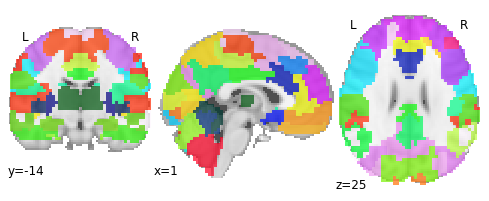

In [82]:
from nilearn import plotting

plotting.plot_roi(atlas_filename, draw_cross=False)

We'll store the filenames of the functional scans in a list that we can later loop over. To test the functions, we will only use the first image in our data set.

In [83]:
fmri_filenames = abide.func_preproc[0]
fmri_filenames

'/mnt/c/brainhackschool/project/data/ABIDE_pcp/cpac/nofilt_noglobal/Pitt_0050003_func_preproc.nii.gz'

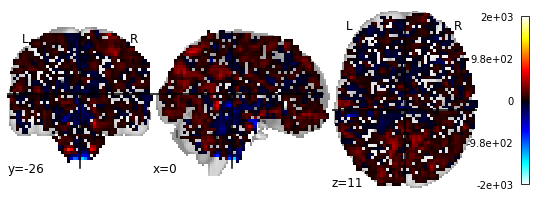

In [84]:
from nilearn import plotting
from nilearn import image
first_Img = image.index_img(fmri_filenames, 1)
plotting.plot_stat_map(first_Img, threshold = 'auto')

Using NiftiLabelsMasker we will create a mask on our functional images with the labels of the chosen atlas and extract the time series in each ROI. Because the data is already preprocessed, we do not need to regress out any confounds.

In [85]:
from nilearn.input_data import NiftiLabelsMasker

masker = NiftiLabelsMasker(labels_img=atlas_filename, 
                           standardize=True, 
                           memory='nilearn_cache', 
                           verbose=1)

time_series = masker.fit_transform(fmri_filenames)

[NiftiLabelsMasker.fit_transform] loading data from /home/mikkel/nilearn_data/basc_multiscale_2015/template_cambridge_basc_multiscale_nii_sym/template_cambridge_basc_multiscale_sym_scale064.nii.gz
Resampling labels


The correlation matrix of the ROIs is computed.

In [86]:
from nilearn.connectome import ConnectivityMeasure

correlation_measure = ConnectivityMeasure(kind='correlation')
correlation_matrix = correlation_measure.fit_transform([time_series])[0]
correlation_matrix.shape

(64, 64)

...and plotted

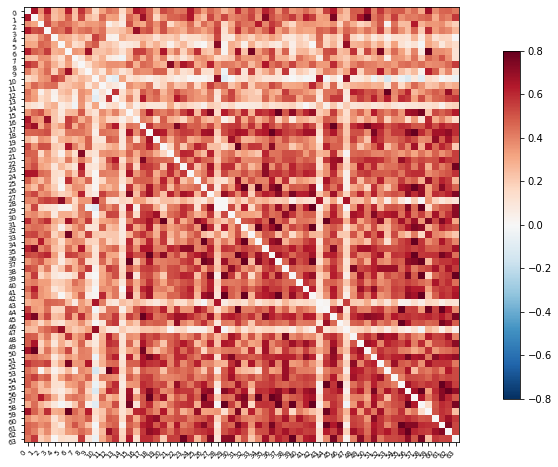

In [87]:
import numpy as np

np.fill_diagonal(correlation_matrix, 0)

plotting.plot_matrix(correlation_matrix, figure=(10, 8),   
                     labels=range(time_series.shape[-1]),
                     vmax=0.8, vmin=-0.8, reorder=False)

All right, this seems to work! Now let's combine this in a for loop.

In [88]:
from nilearn.input_data import NiftiLabelsMasker
from nilearn.connectome import ConnectivityMeasure

# make list of filenames
fmri_filenames = abide.func_preproc

# load atlas
multiscale = datasets.fetch_atlas_basc_multiscale_2015()
atlas_filename = multiscale.scale064

# initialize masker object
masker = NiftiLabelsMasker(labels_img=atlas_filename, 
                           standardize=True, 
                           memory='nilearn_cache', 
                           verbose=0)

# initialize correlation measure
correlation_measure = ConnectivityMeasure(kind='correlation', vectorize=True,
                                         discard_diagonal=True)

all_features = [] # here is where we will put the data (a container)

for i,sub in enumerate(fmri_filenames):
    # extract the timeseries from the ROIs in the atlas
    time_series = masker.fit_transform(sub)
    # create a region x region correlation matrix
    correlation_matrix = correlation_measure.fit_transform([time_series])[0]
    # add to our container
    all_features.append(correlation_matrix)
    # keep track of status
    print('finished %s of %s'%(i+1,len(fmri_filenames)))

finished 1 of 871
finished 2 of 871
finished 3 of 871
finished 4 of 871
finished 5 of 871
finished 6 of 871
finished 7 of 871
finished 8 of 871
finished 9 of 871
finished 10 of 871
finished 11 of 871
finished 12 of 871
finished 13 of 871
finished 14 of 871
finished 15 of 871
finished 16 of 871
finished 17 of 871
finished 18 of 871
finished 19 of 871
finished 20 of 871
finished 21 of 871
finished 22 of 871
finished 23 of 871
finished 24 of 871
finished 25 of 871
finished 26 of 871
finished 27 of 871
finished 28 of 871
finished 29 of 871
finished 30 of 871
finished 31 of 871
finished 32 of 871
finished 33 of 871
finished 34 of 871
finished 35 of 871
finished 36 of 871
finished 37 of 871
finished 38 of 871
finished 39 of 871
finished 40 of 871
finished 41 of 871
finished 42 of 871
finished 43 of 871
finished 44 of 871
finished 45 of 871
finished 46 of 871
finished 47 of 871
finished 48 of 871
finished 49 of 871
finished 50 of 871
finished 51 of 871
finished 52 of 871
finished 53 of 871
fi

Let us save this data to our data directory.

In [105]:
import numpy as np

np.savez_compressed('/mnt/c/brainhackschool/project/data/ABIDE_BASC064_features', a = all_features)

We can load them again like this:

In [106]:
feat_file = '/mnt/c/brainhackschool/project/data/ABIDE_BASC064_features.npz'
X_features = np.load(feat_file)['a']

X_features.shape

(871, 2016)

## Get target variable Y

Accompanying the data set is a csv file containing the phenotypic data. According to the Phenotypic Data Legend which can be downloaded [here](http://fcon_1000.projects.nitrc.org/indi/abide/abide_I.html), the column DX_GROUP has the information about the diagnostic group each participant is in. It is coded as:

- 1 = Autism
- 2 = Control

Let's import the csv.

In [91]:
import pandas as pd
phenotypic = pd.read_csv("/mnt/c/brainhackschool/project/data/ABIDE_pcp/Phenotypic_V1_0b_preprocessed1.csv")

We'll use the file names to get the right values from the DX_GROUP column.

In [107]:
file_ids = []
# get the file IDs from the file names
for f in fmri_filenames:
    file_ids.append(f[-27:-20])

y_asd = []
for i in range(len(phenotypic)):
    for j in range(len(file_ids)):
        if file_ids[j] in phenotypic.FILE_ID[i]:
            y_asd.append(phenotypic.DX_GROUP[i])

## Prepare the data for machine learning

For our test run we will divide our data set into a training and a test set.

In [109]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_features, # x
                                                  y_asd, # y
                                                  test_size = 0.4, # 60%/40% split  
                                                  shuffle = True, # shuffle dataset before splitting
                                                  stratify = y_asd,  # keep distribution of ASD consistent between sets
                                                  random_state = 123 # same split each time
                                                 )

We visualize the distributions:

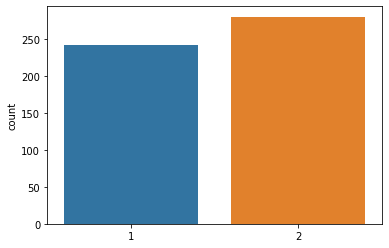

In [110]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.countplot(x = y_train, label = "train")
sns.countplot(x = y_val, label = "test")

## Build Model

### Linear SVC

The classifier that is going to be used here is going to be a Linear Support Vector Classification (SVC). We will use cross-validation to estimate our accuracy.

In [114]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_predict, cross_val_score

l_svc = LinearSVC(max_iter=100000) # more iterations than the default
l_svc.fit(X_train, y_train)

# predict
y_pred_svc = cross_val_predict(l_svc, X_train, y_train, cv=10)
# scores
acc_svc = cross_val_score(l_svc, X_train, y_train, cv=10)

print("Accuracy:", acc_svc)
print("Mean accuracy:", acc_svc.mean())

Accuracy: [0.73584906 0.56603774 0.63461538 0.67307692 0.71153846 0.69230769
 0.55769231 0.63461538 0.55769231 0.59615385]
Mean accuracy: 0.6359579100145136


SVC uses some random parameters under the hood, so the results might differ slightly each time you run the code. This time I got a mean accuracy of 0.636 which means that 63.6% of participants were correctly classified. That is close to the value of 60% we get from the literature (see [this publication by Nielsen et al., 2013](https://www.frontiersin.org/articles/10.3389/fnhum.2013.00599/full)).

### Naive Bayes

Another classifier that can be used is Gaussian Naive Bayes (GNB). It uses Bayes theorem to update probabilities. It also works with the assumption that every pair of features is conditionally independent, given the class. Gaussian Naive Bayes additionally assumes a gaussian distribution of likelihoods.

In [112]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train, y_train, sample_weight=None)

# predict
y_pred_gnb = cross_val_predict(gnb, X_train, y_train, cv=10)
# scores
acc_gnb = cross_val_score(gnb, X_train, y_train, cv=10)

print("Accuracy:", acc_gnb)
print("Mean accuracy:", acc_gnb.mean())

Accuracy: [0.62264151 0.50943396 0.55769231 0.48076923 0.67307692 0.65384615
 0.55769231 0.57692308 0.59615385 0.59615385]
Mean accuracy: 0.5824383164005805


The mean accuracy now was 0.582, so that is even worse than the SVC. Also we haven't looked at our test set yet.

But before we do that, we can try some other things. We could for example add "age" or other variables as features.

In [113]:
# load csv and check out possible additional features
print(phenotypic.columns[2:-10])

Index(['SUB_ID', 'X', 'subject', 'SITE_ID', 'FILE_ID', 'DX_GROUP', 'DSM_IV_TR',
       'AGE_AT_SCAN', 'SEX', 'HANDEDNESS_CATEGORY', 'HANDEDNESS_SCORES', 'FIQ',
       'VIQ', 'PIQ', 'FIQ_TEST_TYPE', 'VIQ_TEST_TYPE', 'PIQ_TEST_TYPE',
       'ADI_R_SOCIAL_TOTAL_A', 'ADI_R_VERBAL_TOTAL_BV', 'ADI_RRB_TOTAL_C',
       'ADI_R_ONSET_TOTAL_D', 'ADI_R_RSRCH_RELIABLE', 'ADOS_MODULE',
       'ADOS_TOTAL', 'ADOS_COMM', 'ADOS_SOCIAL', 'ADOS_STEREO_BEHAV',
       'ADOS_RSRCH_RELIABLE', 'ADOS_GOTHAM_SOCAFFECT', 'ADOS_GOTHAM_RRB',
       'ADOS_GOTHAM_TOTAL', 'ADOS_GOTHAM_SEVERITY', 'SRS_VERSION',
       'SRS_RAW_TOTAL', 'SRS_AWARENESS', 'SRS_COGNITION', 'SRS_COMMUNICATION',
       'SRS_MOTIVATION', 'SRS_MANNERISMS', 'SCQ_TOTAL', 'AQ_TOTAL',
       'COMORBIDITY', 'CURRENT_MED_STATUS', 'MEDICATION_NAME',
       'OFF_STIMULANTS_AT_SCAN', 'VINELAND_RECEPTIVE_V_SCALED',
       'VINELAND_EXPRESSIVE_V_SCALED', 'VINELAND_WRITTEN_V_SCALED',
       'VINELAND_COMMUNICATION_STANDARD', 'VINELAND_PERSONAL_V_SCALED',